<a href="https://colab.research.google.com/github/DietzscheNostoevsky/Learning_Pytorch/blob/main/02_Pytorch_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spiral Dataset

Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).

- Build a loss function and optimizer capable of handling multi-class data (optional extension: use the `Adam optimizer` instead of `SGD`, you may have to experiment with different values of the learning rate to get it working).

- Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).

- Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

## Creating Dataset

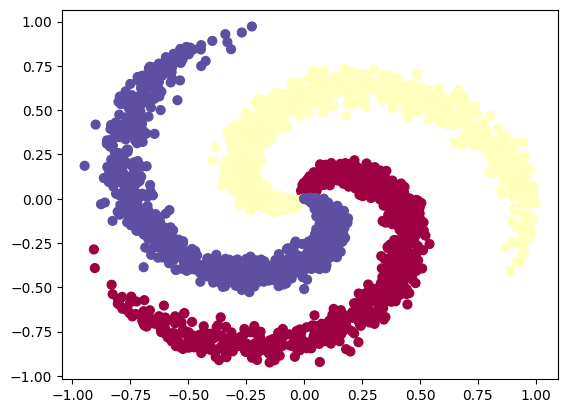

In [1]:
import numpy as np
import matplotlib.pyplot as plt
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

## Test-Train Split

In [3]:
#X_spiral, y_spiral = X, y

# Turning data into tensors 
import torch 

X_spiral = torch.from_numpy(X)
y_spiral = torch.from_numpy(y)

print(X_spiral.shape); print(type(X_spiral))
print(y_spiral.shape); print(type(y_spiral))

torch.Size([3000, 2])
<class 'torch.Tensor'>
torch.Size([3000])
<class 'torch.Tensor'>


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_spiral, y_spiral,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
print(X_train.shape); print(type(X_train))
print(X_test.shape); print(type(X_test))

print(y_train.shape); print(type(y_train))
print(y_test.shape); print(type(y_test))



torch.Size([2400, 2])
<class 'torch.Tensor'>
torch.Size([600, 2])
<class 'torch.Tensor'>
torch.Size([2400])
<class 'torch.Tensor'>
torch.Size([600])
<class 'torch.Tensor'>


In [11]:
for i in range(3):
    print(F"X_train: {X_train[i]}, y_train: {y_train[i]}")


X_train: tensor([ 0.3680, -0.5269], dtype=torch.float64), y_train: 0
X_train: tensor([ 0.3954, -0.5785], dtype=torch.float64), y_train: 0
X_train: tensor([0.1571, 0.1628], dtype=torch.float64), y_train: 0


## Plotting train-test data

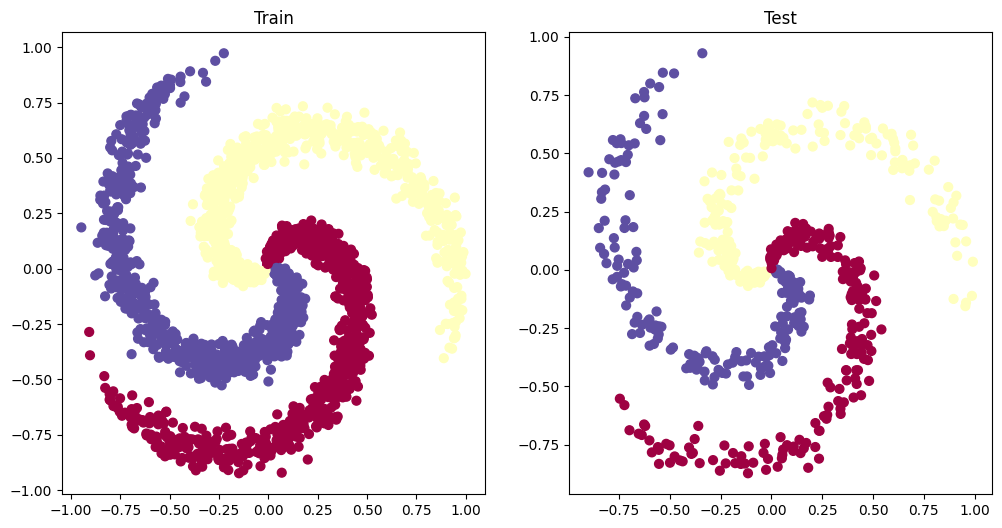

In [14]:
# Training Data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:], s=40, cmap=plt.cm.Spectral)
plt.subplot(1,2,2)
plt.title("Test")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test©[:], s=40, cmap=plt.cm.Spectral)
plt.show()

## Data insights 

In [18]:
print(y_train.unique(return_counts=True))
print(y_test.unique(return_counts=True))


(tensor([0, 1, 2], dtype=torch.uint8), tensor([783, 803, 814]))
(tensor([0, 1, 2], dtype=torch.uint8), tensor([217, 197, 186]))
